In [31]:
#%%

#import argparse
#parser = argparse.ArgumentParser()
#parser.add_argument('-O', action='store_true')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io
import scipy.stats
import scipy.optimize as opt

from gaussparams import GaussParams 
import dynamicmodels
import measurementmodels
import estimationstatistics as estats
import ekf
#import imm
import pda

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
print(f"matplotlib backend: {matplotlib.get_backend()}")
print(f"matplotlib config file: {matplotlib.matplotlib_fname()}")
print(f"matplotlib config dir: {matplotlib.get_configdir()}\n")
plt.close("all")

# set styles
try:
    # gives quite nice plots
    plt_styles = ["science", "grid", "bright", "no-latex"]
    plt.style.use(plt_styles)
    print(f"pyplot using style set {plt_styles}")
except Exception as e:
    print(e)
    print("setting grid and only grid and legend manually")
    plt.rcParams.update(
        {
            # setgrid
            "axes.grid": True,
            "grid.linestyle": ":",
            "grid.color": "k",
            "grid.alpha": 0.5,
            "grid.linewidth": 0.5,
            # Legend
            "legend.frameon": True,
            "legend.framealpha": 1.0,
            "legend.fancybox": True,
            "legend.numpoints": 1,
        }
    )

matplotlib backend: module://ipykernel.pylab.backend_inline
matplotlib config file: c:\users\jeg_j\appdata\local\programs\python\python37-32\lib\site-packages\matplotlib\mpl-data\matplotlibrc
matplotlib config dir: C:\SPB_Data\.matplotlib

pyplot using style set ['science', 'grid', 'bright', 'no-latex']


In [6]:
use_pregen = True
data_file_name = "data_for_pda.mat"
if use_pregen:
    loaded_data = scipy.io.loadmat(data_file_name)
    K   = loaded_data["K"].item()
    Ts  = loaded_data["Ts"].item()
    Xgt = loaded_data["Xgt"].T
    Z   = [zk.T for zk in loaded_data["Z"].ravel()]
    true_association = loaded_data["a"].ravel()
else:
    print("no")
    x0 = np.array([0, 0, 1, 1, 0])
    P0 = np.diag([50, 50, 10, 10, pi / 4]) ** 2
    # model parameters
    sigma_a_true = 0.25
    sigma_omega_true = np.pi / 15
    sigma_z = 3
    # sampling interval a length
    K = 1000
    Ts = 0.1
    # detection and false alarm
    PDtrue = 0.9
    lambdatrue = 3e-4
    np.rando.rng(10)
    # [Xgt, Z, a] = sampleCTtrack(K, Ts, x0, P0, qtrue, rtrue,PDtrue, lambdatrue);
    raise NotImplementedError

Text(0.5, 1.0, 'True trajectory and the nearby measurements')

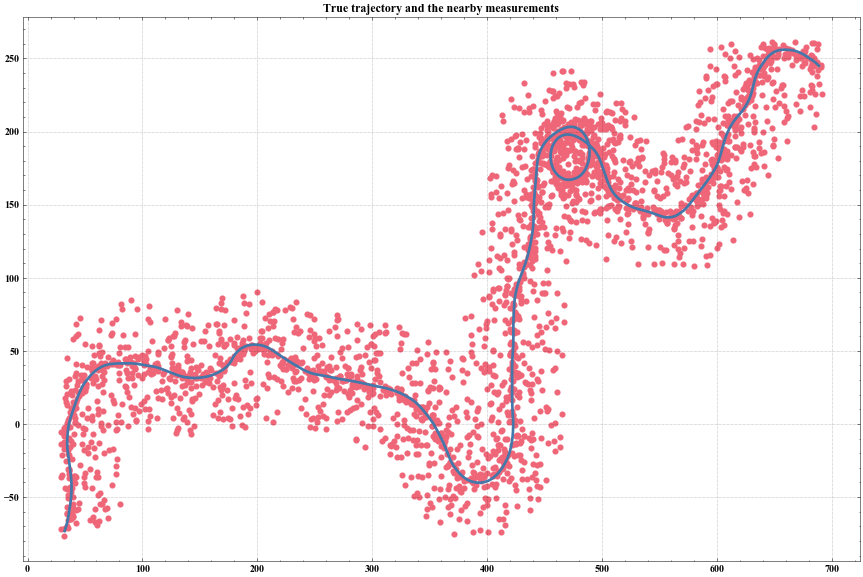

In [7]:
# plot measurements close to the trajectory
fig1, ax1 = plt.subplots(num=1, clear=True, figsize = (15,10))

Z_plot_data = np.empty((0, 2), dtype=float)
plot_measurement_distance = 45
for Zk, xgtk in zip(Z, Xgt):
    to_plot = np.linalg.norm(Zk - xgtk[None:2], axis=1) <= plot_measurement_distance
    Z_plot_data = np.append(Z_plot_data, Zk[to_plot], axis=0)
ax1.scatter(*Z_plot_data.T, color="C1", linewidth=0.1)
ax1.plot(*Xgt.T[:2], color="C0", linewidth=2.7)
ax1.set_title("True trajectory and the nearby measurements")

In [27]:
# Tuning

sigma_a           = 2.2
sigma_z           = 4
PD                = 0.9
clutter_intensity = 0.002
gate_size         = 3

# Initialize
dynamic_model     = dynamicmodels.WhitenoiseAccelleration(sigma_a)
measurement_model = measurementmodels.CartesianPosition(sigma_z)
ekf_filter        = ekf.EKF(dynamic_model, measurement_model)
#imm_filter        = imm.IMM(ekf_filter, measurement_model)
tracker           = pda.PDA(ekf_filter, clutter_intensity, PD, gate_size)

# allocate
NEES    = np.zeros(K)
NEESpos = np.zeros(K)
NEESvel = np.zeros(K)

x_bar_init = np.array([*Z[0][true_association[0] - 1], 0, 0])
x_bar_init= np.array([30, -70, 0, 10])

P_bar_init = np.zeros((4, 4))
P_bar_init[[0, 1], [0, 1]] = 2 * sigma_z ** 2
P_bar_init[[2, 3], [2, 3]] = 20 ** 2

init_state = GaussParams(x_bar_init, P_bar_init)
tracker_update       = init_state
tracker_update_list  = []
tracker_predict_list = []

# Estimate

for k, (Zk, x_true_k) in enumerate(zip(Z, Xgt)):
    tracker_predict = tracker.predict(tracker_update, Ts) 
    tracker_update  = tracker.update(Zk, filter_state=tracker_predict)
    updated_state = tracker_update.mean
    updated_cov   = tracker_update.cov
    NEES[k]    = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(4))
    NEESpos[k] = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(2))
    NEESvel[k] = estats.NEES(updated_state, updated_cov, x_true_k, idxs=np.arange(2, 4))

    tracker_predict_list.append(tracker_predict)
    tracker_update_list.append(tracker_update)

x_hat = np.array([upd.mean for upd in tracker_update_list])

# calculate a performance metric
posRMSE = np.sqrt(np.mean(np.sum((x_hat[:,:2]-Xgt[:,:2])**2,axis=1)))
velRMSE = np.sqrt(np.mean(np.sum((x_hat[:,2:4]-Xgt[:,2:4])**2,axis=1)))

Text(0.5, 1.0, '$\\sigma_a = 2.200$, $\\sigma_z = 4.000$, $posRMSE = 2.63$, $velRMSE = 4.38$')

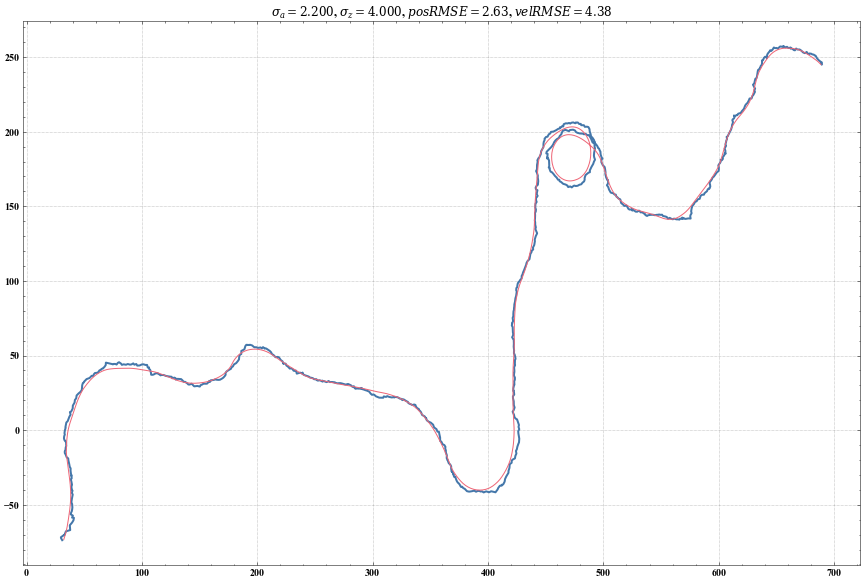

In [28]:
# %% plots
fig3, ax3 = plt.subplots(num=3, clear=True, figsize=(15,10))
ax3.plot(*x_hat.T[:2], label=r"$\hat x$", color="C0",linewidth=2)
ax3.plot(*Xgt.T[:2], label="$x$", color="C1")
ax3.set_title(
    rf"$\sigma_a = {sigma_a:.3f}$, $\sigma_z = {sigma_z:.3f}$, $posRMSE = {posRMSE:.2f}$, $velRMSE = {velRMSE:.2f}$"
)


Text(0.5, 1.0, '79.7% inside 90.0% CI')

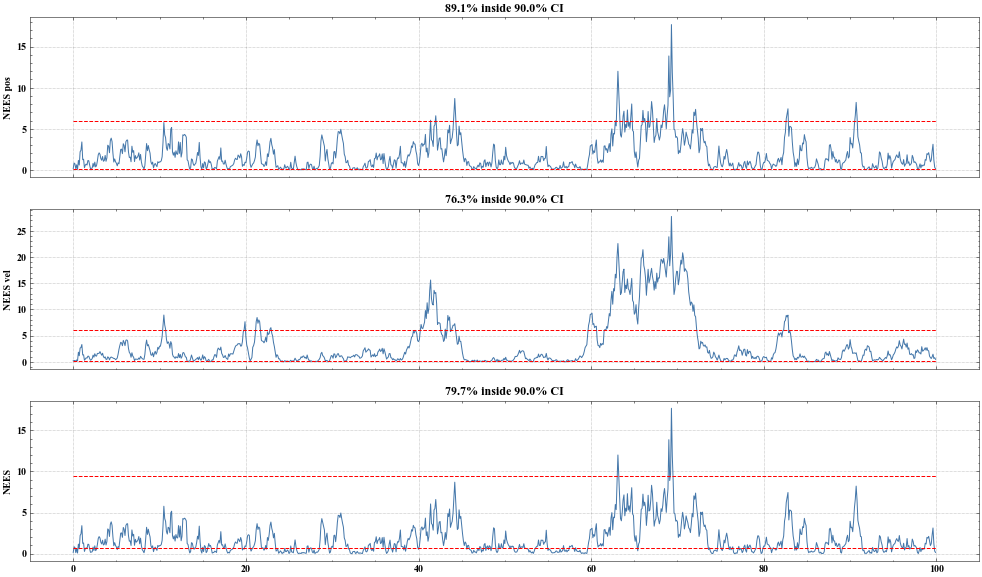

In [42]:
fig4, axs4 = plt.subplots(3, sharex=True, num=4, clear=True, figsize=(17,10))

confprob = 0.9 # probability for confidence interval
CI2 = np.array(scipy.stats.chi2.interval(confprob, 2)) # confidence interval for NEESpos and NEESvel
CI4 = np.array(scipy.stats.chi2.interval(confprob, 4)) # confidence interval for NEES

axs4[0].plot(np.arange(K) * Ts, NEESpos)
axs4[0].plot([0, (K - 1) * Ts], np.repeat(CI2[None], 2, 0), "--r")
axs4[0].set_ylabel("NEES pos")
inCIpos = np.mean((CI2[0] <= NEESpos) * (NEESpos <= CI2[1]))
axs4[0].set_title(f"{inCIpos*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[1].plot(np.arange(K) * Ts, NEESvel)
axs4[1].plot([0, (K - 1) * Ts], np.repeat(CI2[None], 2, 0), "--r")
axs4[1].set_ylabel("NEES vel")
inCIvel = np.mean((CI2[0] <= NEESvel) * (NEESvel <= CI2[1]))
axs4[1].set_title(f"{inCIvel*100:.1f}% inside {confprob*100:.1f}% CI")

axs4[2].plot(np.arange(K) * Ts, NEESpos)
axs4[2].plot([0, (K - 1) * Ts], np.repeat(CI4[None], 2, 0), "--r")
axs4[2].set_ylabel("NEES")
inCI = np.mean((CI2[0] <= NEES) * (NEES <= CI2[1]))
axs4[2].set_title(f"{inCI*100:.1f}% inside {confprob*100:.1f}% CI")

ANEESpos = 1.81 with CI = [1.90, 2.11]
ANEESvel = 3.31 with CI = [1.90, 2.11]
ANEES = 4.49 with CI = [3.85, 4.15]


Text(0, 0.5, ' error')

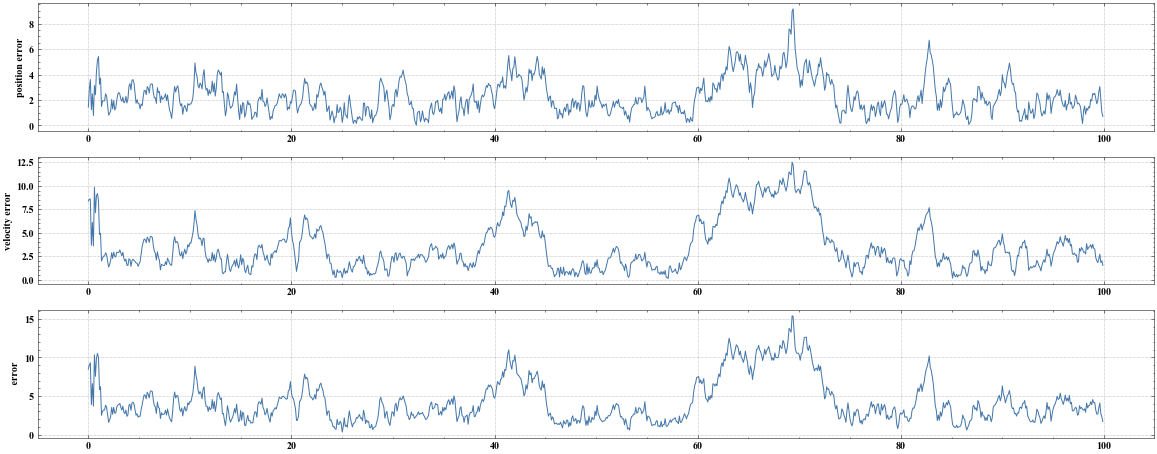

In [49]:
confprob = 0.9 
CI2K = np.array(scipy.stats.chi2.interval(confprob, 2*K))/K 
CI4K = np.array(scipy.stats.chi2.interval(confprob, 4*K))/K 
ANEESpos = np.mean(NEESpos)
ANEESvel = np.mean(NEESvel)
ANEES    = np.mean(NEES)

print(f"ANEESpos = {ANEESpos:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEESvel = {ANEESvel:.2f} with CI = [{CI2K[0]:.2f}, {CI2K[1]:.2f}]")
print(f"ANEES = {ANEES:.2f} with CI = [{CI4K[0]:.2f}, {CI4K[1]:.2f}]")

fig5, axs5 = plt.subplots(3, num=5, clear=True, figsize=(20,8))
axs5[0].plot(np.arange(K) * Ts, np.linalg.norm(x_hat[:, :2] - Xgt[:, :2], axis=1))
axs5[0].set_ylabel("position error")

axs5[1].plot(np.arange(K) * Ts, np.linalg.norm(x_hat[:, 2:4] - Xgt[:, 2:4], axis=1))
axs5[1].set_ylabel("velocity error")

axs5[2].plot(np.arange(K) * Ts, np.linalg.norm(x_hat[:,0:4] - Xgt[:,0:4], axis=1))
axs5[2].set_ylabel(" error")
# %%